In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Neural network libraries
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Embedding
from keras.layers.recurrent import LSTM
#Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt


['Volume IBM', 'Volume GOLD', 'Volume NSQ', 'Volume WTI', 'SO IBM',
       'CCI IBM', 'RSI IBM', 'ULTOSC IBM', 'CCI WTI', 'CCI GOLD',
       'aroonup GOLD', 'ULTOSC GOLD', 'SO NSQ', 'CCI NSQ', 'aroondown NSQ',
       'aroonup NSQ', 'ULTOSC NSQ']

## Preliminary work on the dataset

In [2]:
yahoo_df = pd.read_csv("../data/GOLD.csv")
#yahoo_df = yahoo_df.set_index("Date")
yahoo_df = yahoo_df.set_index("Date")

### Cleaning

In [3]:

X = yahoo_df[['Open', 'ROC_3', 'ROC_4', 'Momentum', '6 Day ROI', '20 Day ROI',
       'EMA_26', 'SRSI_10']]
#X = yahoo_df.drop(columns=["Up down"])

y = yahoo_df["Up down"]



In [4]:
X

,Open,ROC_3,ROC_4,Momentum,6 Day ROI,20 Day ROI,EMA_26,SRSI_10
Date,,,,,,,,
2001-01-10,264.700012,-1.231339,-0.972681,-3.299988,-0.013785,-0.020355,269.387817,0.097033
2001-01-11,264.000000,-1.492537,-1.492537,-3.299988,-0.014925,-0.023307,268.988720,-0.005937
2001-01-12,263.899994,-1.345797,-1.529853,-4.100006,-0.012720,-0.017498,268.611777,0.034205
2001-01-16,263.299988,-0.528910,-1.570098,-4.700012,-0.017537,-0.021190,268.218311,-0.008394
2001-01-17,263.200012,-0.303026,-0.566679,-4.299988,-0.017910,-0.026627,267.846585,0.047434
...,...,...,...,...,...,...,...,...
2022-03-24,1963.599976,1.711086,1.732187,19.500000,0.028092,0.018960,1927.083438,0.402563
2022-03-25,1953.800049,1.723335,1.306651,25.600098,0.006024,0.035675,1929.062447,0.419588
2022-03-28,1932.599976,0.154911,0.984018,11.000000,0.005912,0.021165,1929.843004,0.441452


In [5]:
X.columns

Index(['Open', 'ROC_3', 'ROC_4', 'Momentum', '6 Day ROI', '20 Day ROI',
       'EMA_26', 'SRSI_10'],
      dtype='object')

In [6]:
def normalize(df):
    #df = data
    for column in df:
        df[column]=((df[column]-df[column].mean())/df[column].std())
    return df

# Train, test, val

In [7]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, shuffle=False)

In [8]:
X_train = normalize(X_train).values
X_test = normalize(X_test).values

# Normalize

In [9]:
y_train = y_train.values
y_test = y_test.values

In [10]:
#X_train = normalize(X_train)
#X_test = normalize(X_test)

In [11]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Model

In [12]:
def model_(X,optimizer,activation,loss,metrics):
    #optimizer=str(optimizer)
    #activation=str(activation)
    #loss=str(loss)
    # Define the Model

    # Instantiate the Sequential Model
    model = Sequential()
    model.add(LSTM(units=512, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=256, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=128, activation="sigmoid",return_sequences=False))
    model.add(Dropout(0.4))
    # Add a Dense layer
    model.add(Dense(64, activation="sigmoid"))
    # Add the output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compiling the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [13]:
# Define the Model
metrics=[
    keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.49),
    keras.metrics.BinaryCrossentropy(),
    ]

esm = EarlyStopping(monitor = 'val_binary_accuracy',patience=50)
# Set the optimizer
opt = keras.optimizers.Adam(learning_rate = 0.001)

In [14]:
batch_size = int(round(X_train.shape[0]*0.1))
# # Training the model to the training dataset
model=model_(X_train, opt,'relu','binary_crossentropy',metrics) 
history=model.fit(X_train, y_train, batch_size= batch_size, epochs=1000, verbose=1, shuffle=False,validation_split=0.10)

Epoch 1/1000
9/9 [==============================] - 19s 412ms/step - loss: 0.6828 - binary_accuracy: 0.5966 - binary_crossentropy: 0.6828 - val_loss: 0.6999 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6999
Epoch 2/1000
9/9 [==============================] - 2s 206ms/step - loss: 0.6753 - binary_accuracy: 0.5966 - binary_crossentropy: 0.6753 - val_loss: 0.6945 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6945
Epoch 3/1000
9/9 [==============================] - 2s 209ms/step - loss: 0.6787 - binary_accuracy: 0.5966 - binary_crossentropy: 0.6787 - val_loss: 0.7028 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.7028
Epoch 4/1000
9/9 [==============================] - 2s 213ms/step - loss: 0.6759 - binary_accuracy: 0.5966 - binary_crossentropy: 0.6759 - val_loss: 0.7010 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.7010
Epoch 5/1000
9/9 [==============================] - 1s 95ms/step - loss: 0.6757 - binary_accuracy: 0.5966 - binary_cros

9/9 [==============================] - 1s 92ms/step - loss: 0.6708 - binary_accuracy: 0.5969 - binary_crossentropy: 0.6708 - val_loss: 0.6999 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6999
Epoch 39/1000
9/9 [==============================] - 1s 115ms/step - loss: 0.6714 - binary_accuracy: 0.5963 - binary_crossentropy: 0.6714 - val_loss: 0.7000 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.7000
Epoch 40/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6704 - binary_accuracy: 0.5953 - binary_crossentropy: 0.6704 - val_loss: 0.6997 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6997
Epoch 41/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6696 - binary_accuracy: 0.5937 - binary_crossentropy: 0.6696 - val_loss: 0.6992 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6992
Epoch 42/1000
9/9 [==============================] - 1s 88ms/step - loss: 0.6713 - binary_accuracy: 0.5997 - binary_crossentropy: 0.6

9/9 [==============================] - 2s 212ms/step - loss: 0.6697 - binary_accuracy: 0.5914 - binary_crossentropy: 0.6697 - val_loss: 0.6968 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6968
Epoch 76/1000
9/9 [==============================] - 1s 103ms/step - loss: 0.6696 - binary_accuracy: 0.5969 - binary_crossentropy: 0.6696 - val_loss: 0.6966 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6966
Epoch 77/1000
9/9 [==============================] - 1s 84ms/step - loss: 0.6692 - binary_accuracy: 0.6005 - binary_crossentropy: 0.6692 - val_loss: 0.6968 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6968
Epoch 78/1000
9/9 [==============================] - 1s 85ms/step - loss: 0.6692 - binary_accuracy: 0.5974 - binary_crossentropy: 0.6692 - val_loss: 0.6968 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6968
Epoch 79/1000
9/9 [==============================] - 1s 82ms/step - loss: 0.6704 - binary_accuracy: 0.5977 - binary_crossentropy: 0.

9/9 [==============================] - 1s 72ms/step - loss: 0.6696 - binary_accuracy: 0.5945 - binary_crossentropy: 0.6696 - val_loss: 0.6963 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6963
Epoch 113/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6698 - binary_accuracy: 0.5943 - binary_crossentropy: 0.6698 - val_loss: 0.6963 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6963
Epoch 114/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6699 - binary_accuracy: 0.5979 - binary_crossentropy: 0.6699 - val_loss: 0.6964 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6964
Epoch 115/1000
9/9 [==============================] - 1s 82ms/step - loss: 0.6695 - binary_accuracy: 0.5945 - binary_crossentropy: 0.6695 - val_loss: 0.6963 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6963
Epoch 116/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6695 - binary_accuracy: 0.5974 - binary_crossentropy: 

9/9 [==============================] - 1s 93ms/step - loss: 0.6693 - binary_accuracy: 0.5916 - binary_crossentropy: 0.6693 - val_loss: 0.6963 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6963
Epoch 150/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6693 - binary_accuracy: 0.5984 - binary_crossentropy: 0.6693 - val_loss: 0.6960 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6960
Epoch 151/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6684 - binary_accuracy: 0.5984 - binary_crossentropy: 0.6684 - val_loss: 0.6961 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6961
Epoch 152/1000
9/9 [==============================] - 1s 84ms/step - loss: 0.6690 - binary_accuracy: 0.5974 - binary_crossentropy: 0.6690 - val_loss: 0.6960 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6960
Epoch 153/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6691 - binary_accuracy: 0.6010 - binary_crossentropy: 

9/9 [==============================] - 2s 222ms/step - loss: 0.6690 - binary_accuracy: 0.5945 - binary_crossentropy: 0.6690 - val_loss: 0.6965 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6965
Epoch 187/1000
9/9 [==============================] - 2s 215ms/step - loss: 0.6700 - binary_accuracy: 0.6008 - binary_crossentropy: 0.6700 - val_loss: 0.6963 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6963
Epoch 188/1000
9/9 [==============================] - 2s 231ms/step - loss: 0.6691 - binary_accuracy: 0.5963 - binary_crossentropy: 0.6691 - val_loss: 0.6965 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6965
Epoch 189/1000
9/9 [==============================] - 2s 252ms/step - loss: 0.6685 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6685 - val_loss: 0.6965 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6965
Epoch 190/1000
9/9 [==============================] - 2s 234ms/step - loss: 0.6684 - binary_accuracy: 0.6021 - binary_crossentr

9/9 [==============================] - 1s 83ms/step - loss: 0.6690 - binary_accuracy: 0.5937 - binary_crossentropy: 0.6690 - val_loss: 0.6963 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6963
Epoch 224/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6683 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6683 - val_loss: 0.6964 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6964
Epoch 225/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6694 - binary_accuracy: 0.5953 - binary_crossentropy: 0.6694 - val_loss: 0.6968 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6968
Epoch 226/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6690 - binary_accuracy: 0.6018 - binary_crossentropy: 0.6690 - val_loss: 0.6967 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6967
Epoch 227/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.6689 - binary_accuracy: 0.6008 - binary_crossentropy: 

9/9 [==============================] - 1s 84ms/step - loss: 0.6695 - binary_accuracy: 0.5974 - binary_crossentropy: 0.6695 - val_loss: 0.6962 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6962
Epoch 261/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6686 - binary_accuracy: 0.5997 - binary_crossentropy: 0.6686 - val_loss: 0.6963 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6963
Epoch 262/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6680 - binary_accuracy: 0.5979 - binary_crossentropy: 0.6680 - val_loss: 0.6962 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6962
Epoch 263/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6687 - binary_accuracy: 0.5987 - binary_crossentropy: 0.6687 - val_loss: 0.6960 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6960
Epoch 264/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6693 - binary_accuracy: 0.5987 - binary_crossentropy: 

9/9 [==============================] - 1s 77ms/step - loss: 0.6690 - binary_accuracy: 0.6000 - binary_crossentropy: 0.6690 - val_loss: 0.6958 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6958
Epoch 298/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6688 - binary_accuracy: 0.6008 - binary_crossentropy: 0.6688 - val_loss: 0.6961 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6961
Epoch 299/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6677 - binary_accuracy: 0.6037 - binary_crossentropy: 0.6677 - val_loss: 0.6963 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6963
Epoch 300/1000
9/9 [==============================] - 1s 82ms/step - loss: 0.6685 - binary_accuracy: 0.5982 - binary_crossentropy: 0.6685 - val_loss: 0.6962 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6962
Epoch 301/1000
9/9 [==============================] - 1s 79ms/step - loss: 0.6691 - binary_accuracy: 0.6010 - binary_crossentropy: 

9/9 [==============================] - 1s 76ms/step - loss: 0.6681 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6681 - val_loss: 0.6954 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6954
Epoch 335/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6684 - binary_accuracy: 0.5995 - binary_crossentropy: 0.6684 - val_loss: 0.6953 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6953
Epoch 336/1000
9/9 [==============================] - 1s 88ms/step - loss: 0.6678 - binary_accuracy: 0.6026 - binary_crossentropy: 0.6678 - val_loss: 0.6953 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6953
Epoch 337/1000
9/9 [==============================] - 1s 89ms/step - loss: 0.6675 - binary_accuracy: 0.5997 - binary_crossentropy: 0.6675 - val_loss: 0.6954 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6954
Epoch 338/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.6679 - binary_accuracy: 0.5977 - binary_crossentropy: 

9/9 [==============================] - 1s 67ms/step - loss: 0.6680 - binary_accuracy: 0.6008 - binary_crossentropy: 0.6680 - val_loss: 0.6957 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6957
Epoch 372/1000
9/9 [==============================] - 1s 67ms/step - loss: 0.6676 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6676 - val_loss: 0.6961 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6961
Epoch 373/1000
9/9 [==============================] - 1s 63ms/step - loss: 0.6676 - binary_accuracy: 0.6031 - binary_crossentropy: 0.6676 - val_loss: 0.6962 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6962
Epoch 374/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6675 - binary_accuracy: 0.5995 - binary_crossentropy: 0.6675 - val_loss: 0.6961 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6961
Epoch 375/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6677 - binary_accuracy: 0.6016 - binary_crossentropy: 

9/9 [==============================] - 1s 73ms/step - loss: 0.6677 - binary_accuracy: 0.6023 - binary_crossentropy: 0.6677 - val_loss: 0.6952 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6952
Epoch 409/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6672 - binary_accuracy: 0.6026 - binary_crossentropy: 0.6672 - val_loss: 0.6951 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6951
Epoch 410/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6675 - binary_accuracy: 0.5984 - binary_crossentropy: 0.6675 - val_loss: 0.6949 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6949
Epoch 411/1000
9/9 [==============================] - 1s 80ms/step - loss: 0.6674 - binary_accuracy: 0.6016 - binary_crossentropy: 0.6674 - val_loss: 0.6949 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6949
Epoch 412/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6665 - binary_accuracy: 0.6010 - binary_crossentropy: 

9/9 [==============================] - 1s 87ms/step - loss: 0.6674 - binary_accuracy: 0.6021 - binary_crossentropy: 0.6674 - val_loss: 0.6950 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6950
Epoch 446/1000
9/9 [==============================] - 1s 80ms/step - loss: 0.6676 - binary_accuracy: 0.6013 - binary_crossentropy: 0.6676 - val_loss: 0.6956 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6956
Epoch 447/1000
9/9 [==============================] - 1s 89ms/step - loss: 0.6678 - binary_accuracy: 0.5984 - binary_crossentropy: 0.6678 - val_loss: 0.6958 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6958
Epoch 448/1000
9/9 [==============================] - 1s 81ms/step - loss: 0.6673 - binary_accuracy: 0.6013 - binary_crossentropy: 0.6673 - val_loss: 0.6954 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6954
Epoch 449/1000
9/9 [==============================] - 1s 79ms/step - loss: 0.6678 - binary_accuracy: 0.6013 - binary_crossentropy: 

9/9 [==============================] - 1s 83ms/step - loss: 0.6667 - binary_accuracy: 0.6021 - binary_crossentropy: 0.6667 - val_loss: 0.6955 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6955
Epoch 483/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6667 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6667 - val_loss: 0.6956 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6956
Epoch 484/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6676 - binary_accuracy: 0.5977 - binary_crossentropy: 0.6676 - val_loss: 0.6957 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6957
Epoch 485/1000
9/9 [==============================] - 1s 88ms/step - loss: 0.6667 - binary_accuracy: 0.6039 - binary_crossentropy: 0.6667 - val_loss: 0.6957 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6957
Epoch 486/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6666 - binary_accuracy: 0.5997 - binary_crossentropy: 

9/9 [==============================] - 2s 213ms/step - loss: 0.6657 - binary_accuracy: 0.6013 - binary_crossentropy: 0.6657 - val_loss: 0.6958 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6958
Epoch 520/1000
9/9 [==============================] - 2s 202ms/step - loss: 0.6664 - binary_accuracy: 0.6018 - binary_crossentropy: 0.6664 - val_loss: 0.6958 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6958
Epoch 521/1000
9/9 [==============================] - 2s 204ms/step - loss: 0.6663 - binary_accuracy: 0.6039 - binary_crossentropy: 0.6663 - val_loss: 0.6959 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6959
Epoch 522/1000
9/9 [==============================] - 2s 204ms/step - loss: 0.6656 - binary_accuracy: 0.6050 - binary_crossentropy: 0.6656 - val_loss: 0.6954 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6954
Epoch 523/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.6666 - binary_accuracy: 0.5971 - binary_crossentr

9/9 [==============================] - 1s 71ms/step - loss: 0.6658 - binary_accuracy: 0.6037 - binary_crossentropy: 0.6658 - val_loss: 0.6955 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6955
Epoch 557/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6650 - binary_accuracy: 0.6047 - binary_crossentropy: 0.6650 - val_loss: 0.6951 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6951
Epoch 558/1000
9/9 [==============================] - 1s 81ms/step - loss: 0.6654 - binary_accuracy: 0.5995 - binary_crossentropy: 0.6654 - val_loss: 0.6950 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6950
Epoch 559/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6667 - binary_accuracy: 0.6000 - binary_crossentropy: 0.6667 - val_loss: 0.6954 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6954
Epoch 560/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.6663 - binary_accuracy: 0.6034 - binary_crossentropy: 

9/9 [==============================] - 1s 80ms/step - loss: 0.6662 - binary_accuracy: 0.5977 - binary_crossentropy: 0.6662 - val_loss: 0.6953 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6953
Epoch 594/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6660 - binary_accuracy: 0.6034 - binary_crossentropy: 0.6660 - val_loss: 0.6951 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6951
Epoch 595/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6665 - binary_accuracy: 0.5971 - binary_crossentropy: 0.6665 - val_loss: 0.6960 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6960
Epoch 596/1000
9/9 [==============================] - 1s 81ms/step - loss: 0.6663 - binary_accuracy: 0.5974 - binary_crossentropy: 0.6663 - val_loss: 0.6959 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6959
Epoch 597/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6663 - binary_accuracy: 0.5995 - binary_crossentropy: 

9/9 [==============================] - 1s 78ms/step - loss: 0.6657 - binary_accuracy: 0.5990 - binary_crossentropy: 0.6657 - val_loss: 0.6951 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6951
Epoch 631/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6648 - binary_accuracy: 0.6023 - binary_crossentropy: 0.6648 - val_loss: 0.6955 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6955
Epoch 632/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6662 - binary_accuracy: 0.6037 - binary_crossentropy: 0.6662 - val_loss: 0.6952 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6952
Epoch 633/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6656 - binary_accuracy: 0.5950 - binary_crossentropy: 0.6656 - val_loss: 0.6953 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6953
Epoch 634/1000
9/9 [==============================] - 1s 84ms/step - loss: 0.6657 - binary_accuracy: 0.5966 - binary_crossentropy: 

9/9 [==============================] - 2s 220ms/step - loss: 0.6655 - binary_accuracy: 0.6016 - binary_crossentropy: 0.6655 - val_loss: 0.6961 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6961
Epoch 668/1000
9/9 [==============================] - 2s 217ms/step - loss: 0.6640 - binary_accuracy: 0.6060 - binary_crossentropy: 0.6640 - val_loss: 0.6965 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6965
Epoch 669/1000
9/9 [==============================] - 2s 214ms/step - loss: 0.6638 - binary_accuracy: 0.6068 - binary_crossentropy: 0.6638 - val_loss: 0.6953 - val_binary_accuracy: 0.5376 - val_binary_crossentropy: 0.6953
Epoch 670/1000
9/9 [==============================] - 2s 230ms/step - loss: 0.6645 - binary_accuracy: 0.5992 - binary_crossentropy: 0.6645 - val_loss: 0.6943 - val_binary_accuracy: 0.5211 - val_binary_crossentropy: 0.6943
Epoch 671/1000
9/9 [==============================] - 2s 213ms/step - loss: 0.6644 - binary_accuracy: 0.6070 - binary_crossentr

9/9 [==============================] - 1s 77ms/step - loss: 0.6653 - binary_accuracy: 0.6010 - binary_crossentropy: 0.6653 - val_loss: 0.6958 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6958
Epoch 705/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6672 - binary_accuracy: 0.5995 - binary_crossentropy: 0.6672 - val_loss: 0.6960 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6960
Epoch 706/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6656 - binary_accuracy: 0.6031 - binary_crossentropy: 0.6656 - val_loss: 0.6967 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6967
Epoch 707/1000
9/9 [==============================] - 1s 67ms/step - loss: 0.6647 - binary_accuracy: 0.5966 - binary_crossentropy: 0.6647 - val_loss: 0.6955 - val_binary_accuracy: 0.5376 - val_binary_crossentropy: 0.6955
Epoch 708/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6655 - binary_accuracy: 0.6000 - binary_crossentropy: 

9/9 [==============================] - 1s 83ms/step - loss: 0.6648 - binary_accuracy: 0.5995 - binary_crossentropy: 0.6648 - val_loss: 0.6969 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6969
Epoch 742/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6644 - binary_accuracy: 0.6013 - binary_crossentropy: 0.6644 - val_loss: 0.6955 - val_binary_accuracy: 0.5141 - val_binary_crossentropy: 0.6955
Epoch 743/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6639 - binary_accuracy: 0.6008 - binary_crossentropy: 0.6639 - val_loss: 0.6958 - val_binary_accuracy: 0.5117 - val_binary_crossentropy: 0.6958
Epoch 744/1000
9/9 [==============================] - 1s 87ms/step - loss: 0.6637 - binary_accuracy: 0.6055 - binary_crossentropy: 0.6637 - val_loss: 0.6965 - val_binary_accuracy: 0.5235 - val_binary_crossentropy: 0.6965
Epoch 745/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6638 - binary_accuracy: 0.6034 - binary_crossentropy: 

9/9 [==============================] - 1s 82ms/step - loss: 0.6623 - binary_accuracy: 0.6086 - binary_crossentropy: 0.6623 - val_loss: 0.6969 - val_binary_accuracy: 0.5188 - val_binary_crossentropy: 0.6969
Epoch 779/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6632 - binary_accuracy: 0.6031 - binary_crossentropy: 0.6632 - val_loss: 0.6987 - val_binary_accuracy: 0.5094 - val_binary_crossentropy: 0.6987
Epoch 780/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6642 - binary_accuracy: 0.6047 - binary_crossentropy: 0.6642 - val_loss: 0.6997 - val_binary_accuracy: 0.5164 - val_binary_crossentropy: 0.6997
Epoch 781/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6649 - binary_accuracy: 0.6013 - binary_crossentropy: 0.6649 - val_loss: 0.6988 - val_binary_accuracy: 0.5164 - val_binary_crossentropy: 0.6988
Epoch 782/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6633 - binary_accuracy: 0.6037 - binary_crossentropy: 

9/9 [==============================] - 1s 93ms/step - loss: 0.6638 - binary_accuracy: 0.6065 - binary_crossentropy: 0.6638 - val_loss: 0.6985 - val_binary_accuracy: 0.5117 - val_binary_crossentropy: 0.6985
Epoch 816/1000
9/9 [==============================] - 1s 145ms/step - loss: 0.6630 - binary_accuracy: 0.6034 - binary_crossentropy: 0.6630 - val_loss: 0.6987 - val_binary_accuracy: 0.5117 - val_binary_crossentropy: 0.6987
Epoch 817/1000
9/9 [==============================] - 1s 148ms/step - loss: 0.6625 - binary_accuracy: 0.6078 - binary_crossentropy: 0.6625 - val_loss: 0.6988 - val_binary_accuracy: 0.5188 - val_binary_crossentropy: 0.6988
Epoch 818/1000
9/9 [==============================] - 2s 178ms/step - loss: 0.6626 - binary_accuracy: 0.6089 - binary_crossentropy: 0.6626 - val_loss: 0.6994 - val_binary_accuracy: 0.5117 - val_binary_crossentropy: 0.6994
Epoch 819/1000
9/9 [==============================] - 2s 204ms/step - loss: 0.6638 - binary_accuracy: 0.6023 - binary_crossentro

9/9 [==============================] - 1s 84ms/step - loss: 0.6634 - binary_accuracy: 0.6065 - binary_crossentropy: 0.6634 - val_loss: 0.6992 - val_binary_accuracy: 0.5188 - val_binary_crossentropy: 0.6992
Epoch 853/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6628 - binary_accuracy: 0.6084 - binary_crossentropy: 0.6628 - val_loss: 0.6971 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.6971
Epoch 854/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6615 - binary_accuracy: 0.6060 - binary_crossentropy: 0.6615 - val_loss: 0.6976 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6976
Epoch 855/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6617 - binary_accuracy: 0.6070 - binary_crossentropy: 0.6617 - val_loss: 0.6990 - val_binary_accuracy: 0.5188 - val_binary_crossentropy: 0.6990
Epoch 856/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6611 - binary_accuracy: 0.6154 - binary_crossentropy: 

9/9 [==============================] - 1s 88ms/step - loss: 0.6627 - binary_accuracy: 0.6026 - binary_crossentropy: 0.6627 - val_loss: 0.6998 - val_binary_accuracy: 0.5117 - val_binary_crossentropy: 0.6998
Epoch 890/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6611 - binary_accuracy: 0.6115 - binary_crossentropy: 0.6611 - val_loss: 0.7000 - val_binary_accuracy: 0.5141 - val_binary_crossentropy: 0.7000
Epoch 891/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6619 - binary_accuracy: 0.6104 - binary_crossentropy: 0.6619 - val_loss: 0.7005 - val_binary_accuracy: 0.5164 - val_binary_crossentropy: 0.7005
Epoch 892/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6620 - binary_accuracy: 0.6099 - binary_crossentropy: 0.6620 - val_loss: 0.7007 - val_binary_accuracy: 0.5188 - val_binary_crossentropy: 0.7007
Epoch 893/1000
9/9 [==============================] - 1s 92ms/step - loss: 0.6637 - binary_accuracy: 0.6055 - binary_crossentropy: 

9/9 [==============================] - 1s 76ms/step - loss: 0.6611 - binary_accuracy: 0.6078 - binary_crossentropy: 0.6611 - val_loss: 0.7025 - val_binary_accuracy: 0.5164 - val_binary_crossentropy: 0.7025
Epoch 927/1000
9/9 [==============================] - 1s 79ms/step - loss: 0.6624 - binary_accuracy: 0.6037 - binary_crossentropy: 0.6624 - val_loss: 0.7007 - val_binary_accuracy: 0.5211 - val_binary_crossentropy: 0.7007
Epoch 928/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6613 - binary_accuracy: 0.6081 - binary_crossentropy: 0.6613 - val_loss: 0.6999 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.6999
Epoch 929/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6600 - binary_accuracy: 0.6081 - binary_crossentropy: 0.6600 - val_loss: 0.6987 - val_binary_accuracy: 0.5352 - val_binary_crossentropy: 0.6987
Epoch 930/1000
9/9 [==============================] - 1s 95ms/step - loss: 0.6624 - binary_accuracy: 0.6094 - binary_crossentropy: 

9/9 [==============================] - 1s 93ms/step - loss: 0.6602 - binary_accuracy: 0.6112 - binary_crossentropy: 0.6602 - val_loss: 0.7018 - val_binary_accuracy: 0.5282 - val_binary_crossentropy: 0.7018
Epoch 964/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6597 - binary_accuracy: 0.6112 - binary_crossentropy: 0.6597 - val_loss: 0.7006 - val_binary_accuracy: 0.5399 - val_binary_crossentropy: 0.7006
Epoch 965/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6598 - binary_accuracy: 0.6149 - binary_crossentropy: 0.6598 - val_loss: 0.6991 - val_binary_accuracy: 0.5446 - val_binary_crossentropy: 0.6991
Epoch 966/1000
9/9 [==============================] - 1s 91ms/step - loss: 0.6612 - binary_accuracy: 0.6141 - binary_crossentropy: 0.6612 - val_loss: 0.7003 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.7003
Epoch 967/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6605 - binary_accuracy: 0.6091 - binary_crossentropy: 

9/9 [==============================] - 2s 261ms/step - loss: 0.6613 - binary_accuracy: 0.6081 - binary_crossentropy: 0.6613 - val_loss: 0.7008 - val_binary_accuracy: 0.5258 - val_binary_crossentropy: 0.7008


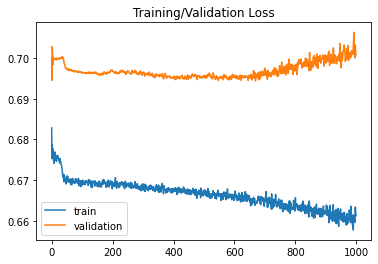

In [15]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Training/Validation Loss');
# Evaluate the model >> model.metrics_names
#print(f'{model.metrics_names}: {model.evaluate(Bitcoin_train, y_train , verbose=1)}')
plt.show()

# Save accuracies

In [16]:
y_prob = model.predict(X_test)
y_pred = list(map(lambda x: 0 if x<0.49 else 1, y_prob))

In [17]:
# Computing Accuracy, Precision and Recall
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.539906103286385


In [18]:
df_prediction = pd.read_csv("../data/model_accuracy_gold.csv", index_col = False)
df_prediction =  df_prediction.drop(columns=["Unnamed: 0"])
df_prediction

,LogReg_pred,LogReg_accuracy,LogReg_prob
0,0,0.534272,0.435015
1,0,0.534272,0.438317
2,0,0.534272,0.441080
3,0,0.534272,0.435446
4,0,0.534272,0.430490
...,...,...,...
1060,1,0.534272,0.528832
1061,1,0.534272,0.523879
1062,1,0.534272,0.521895
1063,1,0.534272,0.517769


In [19]:
df_prediction["RNN_pred"] = y_pred
df_prediction["RNN_accuracy"] = [accuracy for x in range(len(y_pred))]
df_prediction["RNN_prob"] = y_prob

In [20]:
df_prediction

,LogReg_pred,LogReg_accuracy,LogReg_prob,RNN_pred,RNN_accuracy,RNN_prob
0,0,0.534272,0.435015,0,0.539906,0.440501
1,0,0.534272,0.438317,0,0.539906,0.438469
2,0,0.534272,0.441080,0,0.539906,0.438368
3,0,0.534272,0.435446,0,0.539906,0.437083
4,0,0.534272,0.430490,0,0.539906,0.403022
...,...,...,...,...,...,...
1060,1,0.534272,0.528832,0,0.539906,0.486045
1061,1,0.534272,0.523879,1,0.539906,0.510491
1062,1,0.534272,0.521895,0,0.539906,0.478003
1063,1,0.534272,0.517769,0,0.539906,0.462106


In [22]:
df_prediction.to_csv("../data/model_accuracy_gold.csv")